In [1]:
%env CUDA_VISIBLE_DEVICES=1

from transformers import AutoModel, AutoTokenizer, ElectraModel, ElectraConfig
import torch
import json
from tqdm import tqdm

env: CUDA_VISIBLE_DEVICES=1


In [2]:
config = AutoModel.from_pretrained("monologg/koelectra-base-v3-discriminator").config

In [3]:
model = ElectraModel(config=config)
model.load_state_dict(torch.load('../result/Triplet_bert_val_loss_8.pt'))
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [4]:
string = "안녕하세요 저는 박준모 주임입니다. 음성인식후처리 개같아요."
tokenizer.tokenize(string)

['안녕',
 '##하',
 '##세요',
 '저',
 '##는',
 '박준',
 '##모',
 '주임',
 '##입니다',
 '.',
 '음성',
 '##인',
 '##식',
 '##후',
 '##처리',
 '개',
 '##같',
 '##아',
 '##요',
 '.']

# BPE(byte pair embedding)
# Word piece
# Sentence piece

In [37]:
test_file_path = '../data/final/test.json'
with open(test_file_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

In [38]:
label_list, cont_list = [], []
true_sent_list = [_[1] for _ in dataset]
false_sent_list = [_[2] for _ in dataset]

for true_sent in true_sent_list:
    label_list.append(1)
    cont_list.append(true_sent)
for false_sent in false_sent_list:
    label_list.append(0)
    cont_list.append(false_sent)

In [39]:
model.cuda()
cont_proc_list = []
with torch.no_grad():
    for i in cont_list:
        cont_proc_list.append(model(tokenizer(i, return_tensors='pt')['input_ids'].cuda()).last_hidden_state[:,0,:].squeeze(0).detach().cpu().numpy())

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import numpy as np

In [41]:
# create dataframe for visualisation
from sklearn import preprocessing
df_vis = pd.DataFrame()
le = preprocessing.LabelEncoder()
df_vis['content'] = cont_list
df_vis['label'] = le.fit_transform(label_list)

In [42]:
# show label values
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
dictionary

{0: 0, 1: 1}

In [43]:
# diemsnionality reduction using t-SNE

# cont_proc_lst (백터 값)
tsne = TSNE(n_components=2, perplexity=40)
tsne_results = tsne.fit_transform(cont_proc_list)

In [44]:
df_vis['tsne-one'] = tsne_results[:,0]
df_vis['tsne-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-one', ylabel='tsne-two'>

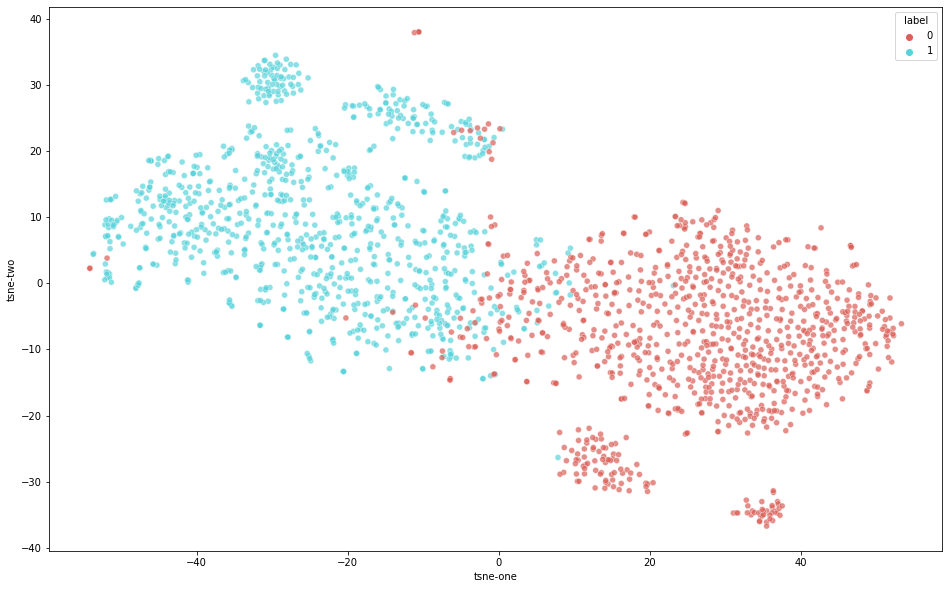

In [45]:
# 2D visualisation using t-SNE (category)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df_vis,
    legend="full",
    alpha=0.7
)

In [47]:
# dimensionlaity reduction using UMAP

# cont_proc_lst (백터 값)
import umap
reducer = umap.UMAP(n_neighbors=15)
umap_results= reducer.fit_transform(cont_proc_list)
df_vis['umap-one'] = umap_results[:,0]
df_vis['umap-two'] = umap_results[:,1]

OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot:xlabel='umap-one', ylabel='umap-two'>

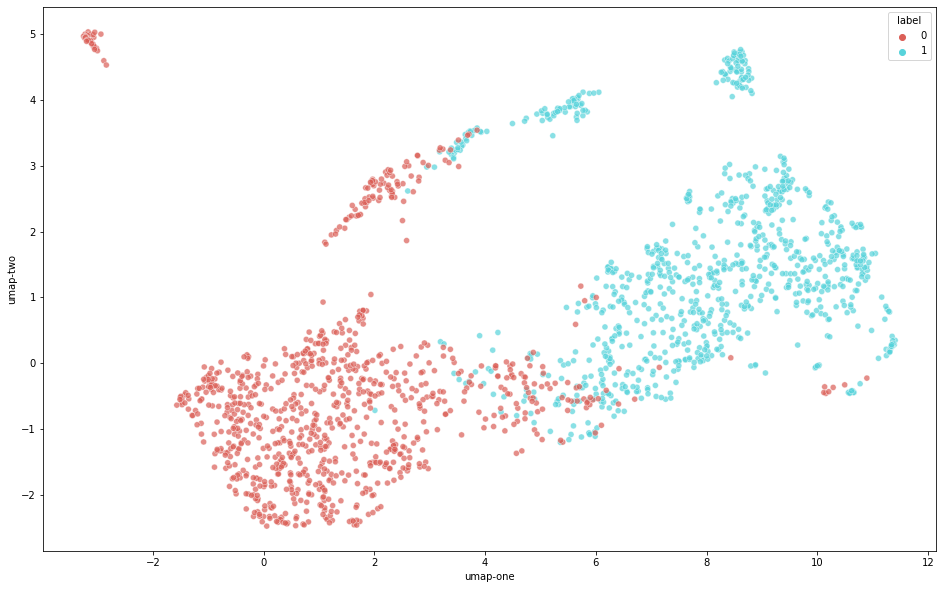

In [48]:
# 2d visualisation using UMAP
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df_vis,
    legend="full",
    alpha=0.7
)